# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [77]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from math import log, sqrt
from itertools import product
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [78]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [79]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in good_arms+bad_arms}
arm_ids = list(arms.keys())

In [80]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 6.121186074898057


In [81]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [82]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [83]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [84]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 611.4999999999999
random: 283.1199999999999


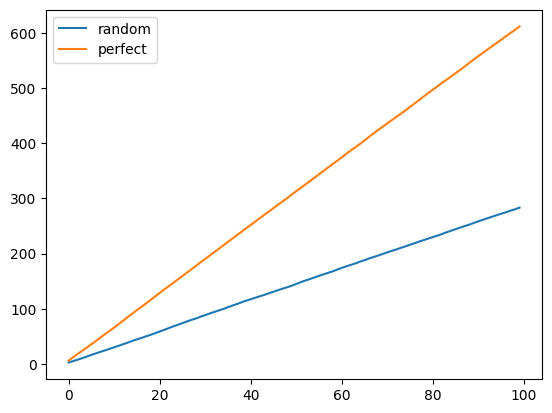

In [85]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 6.1
random: 2.96


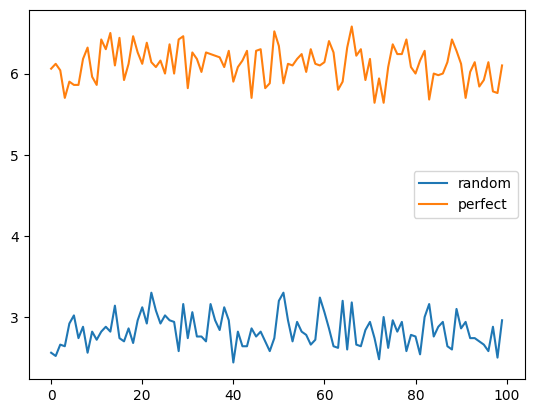

In [86]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [87]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon
        self.recommended_rates = {arm_id: 1.0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        recommendations = []
        sorted_payouts = sorted(
            self.payouts_per_recommendation.items(), key=lambda x: x[1], reverse=True)
        shuffled_arms = copy(arm_ids)
        shuffle(shuffled_arms)

        for i in range(size):
            x = random()
            if x>self.epsilon:
                recommendations.append(sorted_payouts[i][0])
                self.recommended_rates[sorted_payouts[i][0]]
            else:
                recommendations.append(shuffled_arms[i])
                self.recommended_rates[shuffled_arms[i]]
            
        return recommendations



    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [88]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        # te zera w mianowniku moga byc problematyczne
        # - zastanow sie, czy lepiej je obslugiwac w locie czy zainicjalizowac te mape wartosciami niezerowymi
        self.recommended_rates = {arm_id: 0.0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0
    
    def recommend(self, size):

        optimism_payouts = copy(self.payouts_per_recommendation)
        for arm in arm_ids:
            optimism_payouts[arm] += self._optimism(arm) * self.optimism_weight
        optimism_payouts = sorted(
            optimism_payouts, key=lambda x: x[1], reverse=True)
        recommendation = []
        for i in range(size):
            recommendation.append(optimism_payouts[i])
            self.recommended_rates[optimism_payouts[i]]+=1
        return recommendation

    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        self.n = sum(self.recommended_rates.values())
        if self.recommended_rates[arm] == 0:
            return 1.0
        return self.optimism_weight * sqrt(log(self.n) / self.recommended_rates[arm])

In [89]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        ts = {arm_id: betavariate(self.a[arm_id], self.b[arm_id]) for arm_id in arm_ids}
        ts_sorted = sorted(ts, key=lambda x: x[1], reverse=True)
        return ts_sorted[:size]
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1-payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - zgrubne porównanie bandytów

In [90]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [91]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ts_10_20: 6.82
perfect: 6.72
ts_50_5: 6.56
ts_10_1: 6.52
ts_10_10: 6.46
ts_50_50: 6.46
ts_1_5: 6.42
ucb_10: 6.4
ucb_0.01: 6.38
ts_10_5: 6.32
egreedy_0.05: 6.26
ts_5_20: 6.26
ts_20_10: 6.1
ts_50_20: 6.08
ts_5_5: 6.06
ts_1_50: 6.04
ts_50_10: 6.04
ts_1_1: 6.02
ts_5_10: 6.0
ts_10_50: 5.98
ts_20_1: 5.98
ts_50_1: 5.98
egreedy_0.01: 5.94
ts_5_50: 5.94
ts_20_5: 5.94
ts_20_20: 5.94
ts_20_50: 5.92
ts_1_10: 5.9
ts_5_1: 5.9
ts_1_20: 5.86
ucb_0.1: 5.82
ucb_1: 5.74
egreedy_0.25: 5.1
egreedy_0.1: 4.76
random: 3.0


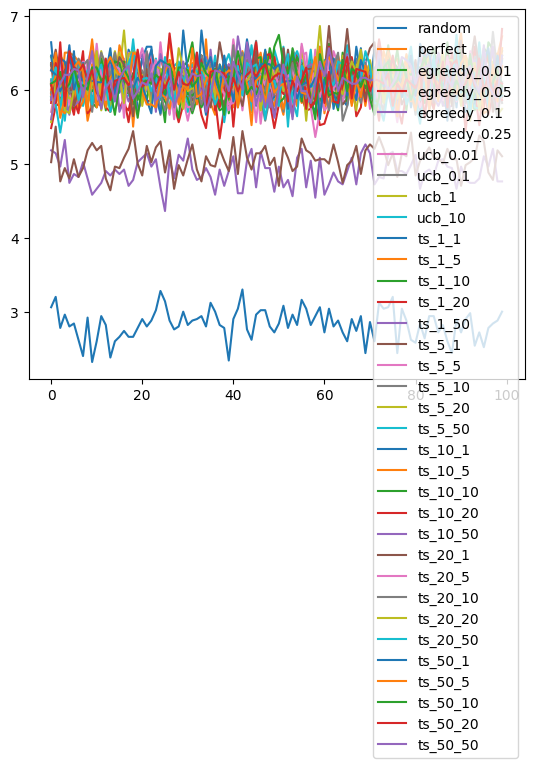

In [92]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

ts_1_5: 617.64
ts_50_1: 616.6200000000001
ts_20_1: 615.24
ts_10_1: 614.98
ucb_1: 613.7999999999998
ts_10_20: 613.58
ts_1_20: 613.5400000000003
ts_50_10: 613.3599999999998
ts_20_20: 613.0400000000002
ts_5_1: 612.88
ts_5_50: 612.48
ts_5_10: 612.2199999999999
ts_50_20: 612.0799999999999
ts_10_50: 611.9
ucb_0.01: 611.8999999999999
ts_1_10: 611.8199999999997
ts_5_20: 611.7600000000002
ts_10_10: 611.72
ucb_0.1: 611.44
ts_50_50: 611.36
perfect: 611.3599999999999
ts_20_50: 610.6999999999999
ts_50_5: 610.6000000000001
ts_20_5: 610.5200000000003
egreedy_0.01: 610.3599999999999
ts_1_50: 610.2600000000001
ts_10_5: 610.1
ts_5_5: 609.8399999999999
ts_1_1: 609.0599999999997
ts_20_10: 608.6800000000001
ucb_10: 607.6000000000001
egreedy_0.05: 591.54
egreedy_0.25: 506.0799999999999
egreedy_0.1: 489.29999999999995
random: 283.18


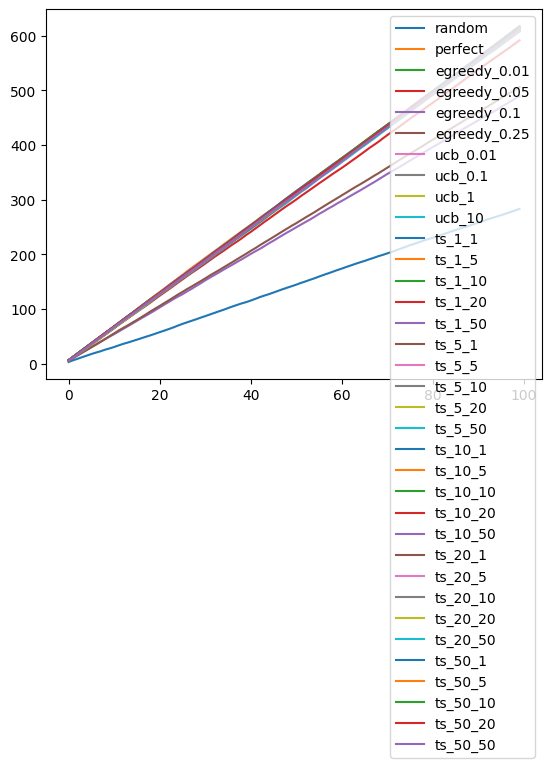

In [93]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [107]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    rel =  0
    for arm in recommendation:
        if arm.pull():
            rel+=1
    return rel
all_relevant = relevant(arms.values())

In [108]:
# obliczmy precision@k i recall@k (zgodnie ze wzorami z wykladu)
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    rel_k = 0
    for i in range(k):
        if recommendation[i].pull():
            rel_k+=1
    return rel_k/k


def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    rel_k = 0
    for i in range(k):
        if recommendation[i].pull():
            rel_k+=1
    return rel_k / all_relevant

In [109]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 0.6666666666666666
Recall@3 for bandit ts_50_50: 0.03571428571428571


In [117]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits = [bandits[0], bandits[1], bandits[4], bandits[8], bandits[15]]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, wypisujemy srednie wartosci
# powtarzamy dla kazdego k
for k in k_vals:
  for bandit in tesing_bandits:
    bandit.recommend(k)
    recommendation = [arms[arm_id] for arm_id in recommendation_ids]
    print(f'Precision@{k} for bandit {bandit.bandit_id}: {precision_at_k(recommendation, k)}')
    print(f'Recall@{k} for bandit {bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')


Precision@3 for bandit random: 0.6666666666666666
Recall@3 for bandit random: 0.0
Precision@3 for bandit perfect: 0.6666666666666666
Recall@3 for bandit perfect: 0.07142857142857142
Precision@3 for bandit egreedy_0.1: 1.0
Recall@3 for bandit egreedy_0.1: 0.03571428571428571
Precision@3 for bandit ucb_1: 0.6666666666666666
Recall@3 for bandit ucb_1: 0.10714285714285714
Precision@3 for bandit ts_5_1: 0.6666666666666666
Recall@3 for bandit ts_5_1: 0.07142857142857142
Precision@5 for bandit random: 0.4
Recall@5 for bandit random: 0.14285714285714285
Precision@5 for bandit perfect: 0.8
Recall@5 for bandit perfect: 0.10714285714285714
Precision@5 for bandit egreedy_0.1: 0.4
Recall@5 for bandit egreedy_0.1: 0.14285714285714285
Precision@5 for bandit ucb_1: 0.4
Recall@5 for bandit ucb_1: 0.07142857142857142
Precision@5 for bandit ts_5_1: 0.6
Recall@5 for bandit ts_5_1: 0.14285714285714285
Precision@10 for bandit random: 0.7
Recall@10 for bandit random: 0.17857142857142858
Precision@10 for band